In [1]:
import duckdb
import pandas as pd

print("DuckDB version:", duckdb.__version__)
print("Connecting to OpenFoodFacts via DuckDB...")

query = """
    INSTALL httpfs;
    LOAD httpfs;
    SELECT
        code,
        product_name,
        ingredients_text,
        nova_group
    FROM read_parquet('https://huggingface.co/datasets/openfoodfacts/product-database/resolve/main/food.parquet')
    WHERE ingredients_text IS NOT NULL
        AND nova_group IS NOT NULL
    LIMIT 30000;
"""

df = duckdb.query(query).to_df()
print(f"Data loaded: {len(df)} rows.")
print("Data loaded. Here are the first few rows:")
print(df.head())

DuckDB version: 1.4.2
Connecting to OpenFoodFacts via DuckDB...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data loaded: 30000 rows.
Data loaded. Here are the first few rows:
            code                                       product_name  \
0  0000105000011  [{'lang': 'main', 'text': 'Chamomile Herbal Te...   
1  0000105000042  [{'lang': 'main', 'text': 'Lagg's, herbal tea,...   
2  0000105000196  [{'lang': 'main', 'text': 'Apple & Cinnamon Te...   
3  0000105000219  [{'lang': 'main', 'text': 'Green Tea'}, {'lang...   
4  0000105000417  [{'lang': 'main', 'text': 'Lagg's, dieter's he...   

                                    ingredients_text  nova_group  
0  [{'lang': 'main', 'text': 'CHAMOMILE FLOWERS.'...           1  
1  [{'lang': 'main', 'text': 'Peppermint.'}, {'la...           1  
2  [{'lang': 'main', 'text': 'TEA, CINNAMON & NAT...           4  
3  [{'lang': 'main', 'text': 'GREEN TEA.'}, {'lan...           1  
4  [{'lang': 'main', 'text': 'Andropogon citratus...           1  


In [2]:
import re

def clean_openfoodfacts_data(input_data, is_ingredient_list=False):
    if input_data is None: return "unknown"
    
    # Convert list/dict to string if needed
    if not isinstance(input_data, str):
        input_data = str(input_data)

    text = ""
    
    # --- STRATEGY 1: Regex Extraction ---
    # Finds 'text': 'VALUE' (handling both single and double quotes)
    pattern = r"['\"]text['\"]\s*:\s*(['\"])(.*?)\1"
    matches = re.findall(pattern, input_data)
    
    if matches:
        # Pick the longest match (usually the most complete)
        candidates = [m[1] for m in matches]
        text = max(candidates, key=len) if candidates else candidates[0]
        
    # --- STRATEGY 2: Fallback ---
    if not text:
        text = input_data
        text = re.sub(r"[{}[\]']", "", text)
        text = re.sub(r"lang\s*:\s*\w+", "", text)
        text = re.sub(r"text\s*:", "", text)

    # --- COMMON POLISH ---
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    # --- INGREDIENT SPECIFIC CLEANING ---
    # Only remove percentages and brackets if it's an ingredient list. 
    # (We might want brackets in a product name like "Soup (Tomato)")
    if is_ingredient_list:
        text = re.sub(r'\d+(\.\d+)?\s?%', '', text) # Remove percentages
        text = re.sub(r'\([^)]*\)', '', text)       # Remove (...)
        text = re.sub(r'[^a-z0-9, ]', '', text)     # Remove special chars
    else:
        # Product name cleaning (less aggressive)
        text = re.sub(r'[^a-z0-9, \-]', '', text)   # Keep hyphens for names

    return text

# --- APPLY TO BOTH COLUMNS ---
print("Cleaning Ingredients...")
df['clean_ingredients'] = df['ingredients_text'].apply(lambda x: clean_openfoodfacts_data(x, is_ingredient_list=True))

print("Cleaning Product Names...")
df['clean_product_name'] = df['product_name'].apply(lambda x: clean_openfoodfacts_data(x, is_ingredient_list=False))

# Filter out empty rows
df = df[df['clean_ingredients'] != ""]
df = df[df['clean_product_name'] != ""]
df = df[df['clean_product_name'] != "unknown"]

print(f"✅ Cleanup Complete. Rows: {len(df)}")
df[['clean_product_name', 'clean_ingredients', 'nova_group']].head(5)

Cleaning Ingredients...
Cleaning Product Names...
✅ Cleanup Complete. Rows: 29949


,clean_product_name,clean_ingredients,nova_group
0,chamomile herbal tea,chamomile flowers,1
1,"laggs, herbal tea, peppermint",peppermint,1
2,apple cinnamon tea,"tea, cinnamon natural apple flavor",4
3,green tea,green tea,1
4,"laggs, dieters herbal tea","andropogon citratus, uva ursi, hibiscus flower...",1


C:\Users\USER\AppData\Local\Temp\ipykernel_20988\859740206.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="nova_group", data=df, palette='viridis')


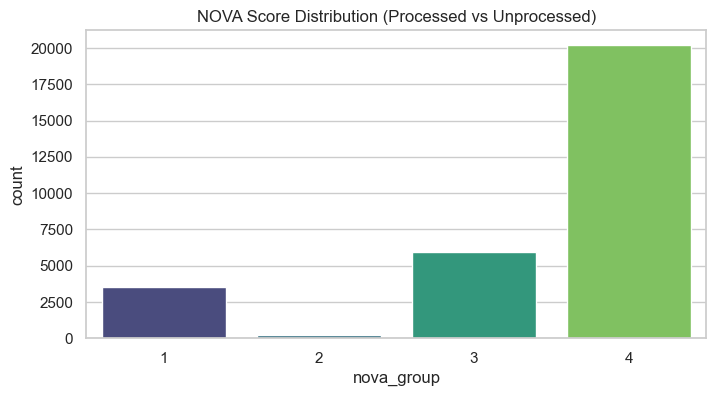

C:\Users\USER\AppData\Local\Temp\ipykernel_20988\859740206.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=word_df, palette='magma')


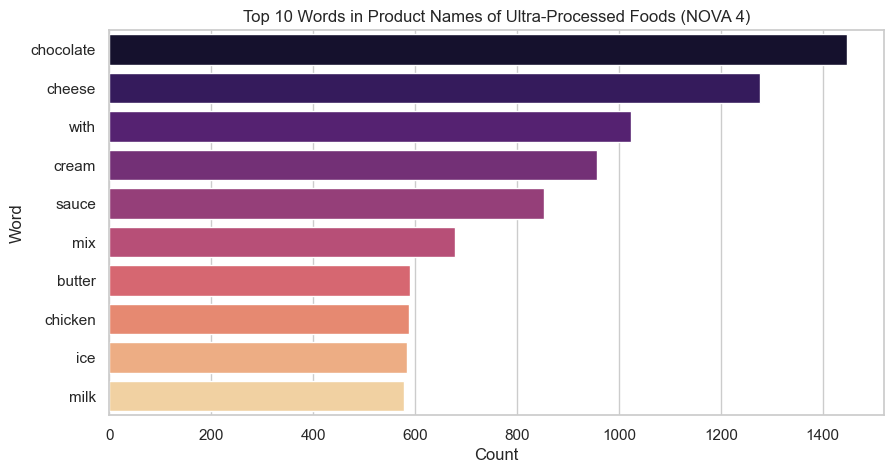

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.countplot(x="nova_group", data=df, palette='viridis')
plt.title("NOVA Score Distribution (Processed vs Unprocessed)")
plt.show()

nova4 = df[df['nova_group'] == 4]
all_names = " ".join(nova4['clean_product_name'])
words = all_names.split()

word_counts = Counter(words).most_common(10)

word_df = pd.DataFrame(word_counts, columns=['Word', 'Count'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Word', data=word_df, palette='magma')
plt.title("Top 10 Words in Product Names of Ultra-Processed Foods (NOVA 4)")
plt.show()

In [4]:
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

X = df['clean_ingredients']
y = df['nova_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
)

print("    Training Model (learning chemical patterns)...")
model.fit(X_train, y_train)
print("    Model training complete.")

test_foods = [
    "wheat flour, sugar, palm oil, high fructose corn syrup, blue 1, artificial flavor", # UPF (Cookie)
    "apples", # Unprocessed
    "olive oil", # Culinary Ingredient (NOVA 2 - The rare class)
    "canned corn, water, salt" # Processed (NOVA 3)
]

print("\n--- LIVE TEST ---")
preds = model.predict(test_foods)
for food, score in zip(test_foods, preds):
    print(f"Input: {food[:30]}... --> Predicted NOVA Group: {score}")
    
os.makedirs('models', exist_ok=True)

with open('models/nova_classifier.pkl', 'wb') as f:
    pickle.dump(model, f)
    
print("\nModel saved to services/ml-core/models/nova_classifier.pkl")

    Training Model (learning chemical patterns)...
    Model training complete.

--- LIVE TEST ---
Input: wheat flour, sugar, palm oil, ... --> Predicted NOVA Group: 4
Input: apples... --> Predicted NOVA Group: 1
Input: olive oil... --> Predicted NOVA Group: 2
Input: canned corn, water, salt... --> Predicted NOVA Group: 3

Model saved to services/ml-core/models/nova_classifier.pkl
